In [4]:
import pickle
from typing import List

import matplotlib.pyplot as plt
import pandas as pd

from plotting import pie_chart

### Import the data

In [5]:
with open('data/train_v2_set_top_5.pkl', 'rb') as f:
    train = pickle.load(f)

with open('data/test_v2_set_top_5.pkl', 'rb') as f:
    test = pickle.load(f)

In [6]:
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

### Data Exploration

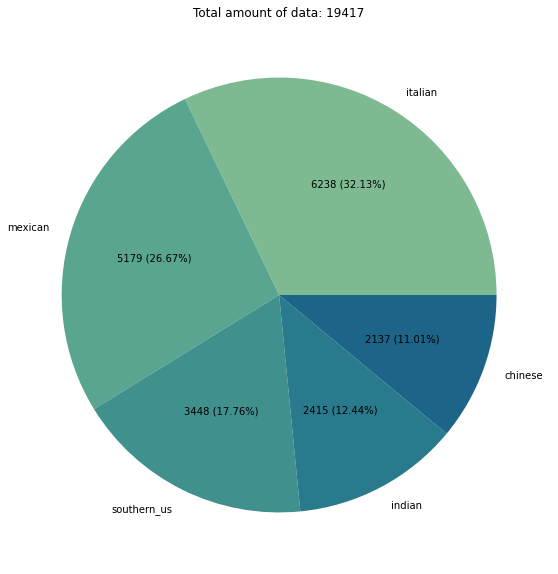

In [7]:
value_counts = train_df['cuisine'].value_counts()

pie_chart(value_counts)

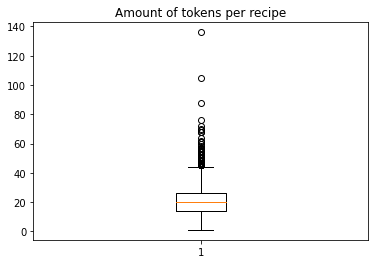

In [8]:
train_df['tokens'] = train_df['ingredients'].str.split()
train_df['n_ingredients'] = train_df['tokens'].apply(len)

plt.boxplot(train_df['n_ingredients'])
plt.title('Amount of tokens per recipe')
plt.show()

Let's check out some of the long recipes

In [9]:
train_df.loc[train_df['n_ingredients'] > 80, 'ingredients'].tolist()

['canned black beans seasoned bread crumbs prepared horseradish jalapeno chilies chili powder buttermilk purple onion salsa crispy rice cereal chicken eggs kosher salt milk cream of chicken soup hard-boiled egg Tabasco Pepper Sauce garlic cilantro leaves creole seasoning long grain white rice mustard black pepper shredded cheddar cheese ground black pepper low sodium chicken broth onion powder paprika salt green pepper boneless skinless chicken breast halves mayonaise cider vinegar garlic powder boneless chicken breast halves boneless skinless chicken breasts butter chopped celery all-purpose flour scallions corn kernel whole',
 'fettucine fresh marjoram minced garlic olive oil garlic powder large eggs Alfredo sauce vegetable oil cajun seasoning shredded romano cheese basil dried leaves salt cayenne pepper scallions red bell pepper boneless skinless chicken breast halves soba pasta sauce kosher salt milk fresh ginger ground black pepper flour cooked chicken coarse salt lemon diced toma

The data could use some cleaning, there are useless words like 'fresh', there are plurals 'chillies' vs 'chili', capitalized words etc

lets see if there are non-alphanumerical characters

In [10]:
# Find all non-alphanumeric chars

import re


def find_non_alpha(row):
    return re.findall("[^A-Za-z ]", row) or None


non_alpha_chars = (train_df['ingredients']
                   .apply(find_non_alpha)
                   .dropna()
                   .explode()
                   .unique()
                   .tolist())
non_alpha_chars

['-',
 '&',
 ',',
 '2',
 '%',
 'è',
 'î',
 "'",
 '4',
 'é',
 '8',
 '1',
 '3',
 '™',
 'ú',
 'â',
 '®',
 '!',
 '(',
 ')',
 '.',
 '5',
 '7',
 'ç',
 '’',
 '0',
 '9',
 'í',
 '/']

In [11]:
token_counts = train_df['tokens'].explode().value_counts()
token_counts.head(50)

salt           12387
pepper         12336
oil            11629
garlic          9347
ground          9247
fresh           8538
cheese          7760
chicken         5850
olive           5646
sauce           5593
onions          5567
black           5412
sugar           5035
powder          5000
tomatoes        4934
flour           4454
water           4437
red             4396
chopped         4170
green           3944
butter          3943
onion           3716
cloves          3592
corn            3404
cilantro        3381
white           3353
cream           3301
juice           3189
eggs            3018
cumin           3006
vegetable       2826
chili           2531
ginger          2513
leaves          2444
dried           2407
milk            2406
large           2371
lemon           2317
rice            2276
lime            2259
broth           2257
all-purpose     2225
vinegar         2152
parmesan        2101
wine            2081
beans           2006
grated          1995
soy          

In [12]:
# Total amount of tokens
len(token_counts)

2791

### Data cleaning

In [ ]:
from tqdm import tqdm
from unidecode import unidecode

import spacy

nlp = spacy.load('en_core_web_lg')

tqdm.pandas()

def keep_only_nouns(ingredients: str) -> List[str]:
    return [str(word) for word in nlp(ingredients) if not word.pos_ in ['ADJ', 'ADV', 'VERB', 'AUX', 'CONJ', 'NUM']]

def convert_to_singular(word):
    if word.endswith('oes'):
        return word.replace('oes', 'o')
    if word.endswith('ies'):
        return word.replace('ies', 'y')
    if word.endswith('as'):
        return word.replace('as', 'a')
    if word.endswith('es'):
        return word.replace('es', 'e')
    if word.endswith('s'):
        return word.rstrip('s')
    return word

def clean_ingredients(ingredients: str) -> List[str]:
    ingredients = unidecode(ingredients)
    ingredients = ingredients.lower()
    for c in non_alpha_chars:
        ingredients = ingredients.replace(c, '')
    ingredients_list = keep_only_nouns(ingredients)
    ingredients_list = list(set([convert_to_singular(word) for word in ingredients_list]))
    return ingredients_list



In [ ]:
train_df['tokens'] = train_df['ingredients'].progress_apply(clean_ingredients)
train_df['n_ingredients'] = train_df['tokens'].apply(len)

In [ ]:
train_df

In [ ]:
test_df['tokens'] = test_df['ingredients'].progress_apply(clean_ingredients)
test_df['n_ingredients'] = test_df['tokens'].apply(len)

In [ ]:
token_counts = train_df['tokens'].explode().value_counts()
token_counts

In [ ]:
train_df.to_csv('data/train.csv', index=False)
test_df.to_csv('data/test.csv', index=False)